## Introduction

Firstly, i have to say that i'm begginer in kaggle, so if you think that this notebook can be improved please comment, it's going to be a pleasure to read.

Well, the idea in this notebook is to use transfer learning, the features is obtained from inceptionV3 and the classfier i opted to use Logistic regression, random forest and XGBoost. Firstly, for reasons of low RAM memory i decide to use part of the images (400 for each class) and then use train_test_split to separate the data. 

##  Setup

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input as preprocess_iv3_input
from keras import applications
from keras.models import Model
import random as rd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt     

In [2]:
#this is test code
iv3_model = applications.inception_v3.InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(224, 224,3))
iv3_model.layers.pop()
output = iv3_model.layers[-1].output
iv3_model = Model(iv3_model.input, output)
iv3_model.trainable = False

2022-10-19 01:48:41.877430: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


87924736/87910968 [==============================] - 1s 0us/step


### Functions

Here i define two functions to extract the features from inceptionV3. The first function is to preprocess the images and the second to extract the features from the images.

In [3]:
img_dir='../input/shoe-vs-sandal-vs-boot-dataset-15k-images/Shoe vs Sandal vs Boot Dataset/Boot/'

def process_image2arr(path, img_dims=(224, 224)):
    img = image.load_img(path, target_size=img_dims)
    img_arr = image.img_to_array(img)
    img_arr = np.expand_dims(img_arr, axis=0)
    img_arr = preprocess_iv3_input(img_arr)
    return img_arr

def extract_tl_features(model, image_file_name, image_dir=img_dir):
    
    pr_img = process_image2arr(image_dir+image_file_name) #the function above 
    tl_features = model.predict(pr_img)
    tl_features = np.reshape(tl_features, 2048*5*5)
    return tl_features

## Extracting the features for each class and then concatenating the data

In this part i'm creating a diferent dataframe for each class of shoes. I'm selecting 400 images (randomly obtained) and applying the function previously mentioned, but i choose to write in the variable what type of shoes is in the file path. But the idea here is to form a representative data of these images and i think with this method we can achieve this objective.

### Boots

In [4]:
img_dir='../input/shoe-vs-sandal-vs-boot-dataset-15k-images/Shoe vs Sandal vs Boot Dataset/Boot/'
img_names=os.listdir('../input/shoe-vs-sandal-vs-boot-dataset-15k-images/Shoe vs Sandal vs Boot Dataset/Boot')

n = len(img_names)
m = np.random.randint(1,n,400)
img_names = pd.DataFrame(img_names,columns = ['img_name'])
img_list = img_names.iloc[m,]

In [5]:
img_features = dict()
img_names = []

#montar a base de dados com os features das imagens (como são varias imagens demora)
for img in img_list['img_name']:
    img_features[img] = extract_tl_features(model=iv3_model, image_file_name=img, image_dir=img_dir)

2022-10-19 01:48:45.553807: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [6]:
data_boot = pd.DataFrame.from_dict(img_features, orient='index')
#Colocar uma variável para ser categórica no modelo
data_boot['Type']='Boot' 
data_boot.head()

,0,1,2,3,4,5,6,7,8,9,...,51191,51192,51193,51194,51195,51196,51197,51198,51199,Type
boot (276).jpg,0.000000,0.843215,0.0,1.091496,0.000000,1.022895,0.455113,0.058379,0.602439,0.0,...,1.794804,0.0,2.184465,0.0,1.488901,0.000000,0.778299,0.000000,0.000000,Boot
boot (2359).jpg,0.000000,0.874627,0.0,1.217293,0.000000,0.464599,0.000000,0.086532,1.159001,0.0,...,2.228059,0.0,1.198201,0.0,1.707577,0.000000,0.000000,0.000000,0.956107,Boot
boot (1926).jpg,0.000000,1.133155,0.0,0.591662,0.000000,0.932431,1.014284,0.000000,1.226964,0.0,...,2.452534,0.0,1.818035,0.0,1.585546,0.000000,0.000000,0.000000,0.000000,Boot
boot (1496).jpg,0.069215,1.436697,0.0,1.298439,0.000000,0.769449,0.000000,0.000000,0.696022,0.0,...,0.853676,0.0,0.999509,0.0,0.381284,0.919508,0.000000,0.000000,0.054545,Boot
boot (3689).jpg,0.000000,0.284661,0.0,0.880076,0.281147,0.560489,0.000000,0.000000,0.000000,0.0,...,0.181421,0.0,0.000000,0.0,0.537321,0.685753,0.000000,0.496367,1.295598,Boot


### Sandals

In [7]:
img_dir='../input/shoe-vs-sandal-vs-boot-dataset-15k-images/Shoe vs Sandal vs Boot Dataset/Sandal/'
img_names=os.listdir('../input/shoe-vs-sandal-vs-boot-dataset-15k-images/Shoe vs Sandal vs Boot Dataset/Sandal')
n = len(img_names)
m = np.random.randint(1,n,400)
img_names = pd.DataFrame(img_names,columns = ['img_name'])
img_list = img_names.iloc[m,]

In [8]:
img_features = dict()
img_names = []

#montar a base de dados com os features das imagens (como são varias imagens demora)
for img in img_list['img_name']:
    img_features[img] = extract_tl_features(model=iv3_model, image_file_name=img, image_dir=img_dir)

In [9]:
data_sandal = pd.DataFrame.from_dict(img_features, orient='index')
#Colocar uma variável para ser categórica no modelo
data_sandal['Type']='Sandal' 
data_sandal.head()

,0,1,2,3,4,5,6,7,8,9,...,51191,51192,51193,51194,51195,51196,51197,51198,51199,Type
Sandal (132).jpg,0.0,1.040755,0.0,0.334661,0.317414,0.680337,1.184022,0.0,0.000000,0.000000,...,3.895692,0.695535,0.000000,2.576543,0.000000,0.000000,0.044239,0.0,0.000000,Sandal
Sandal (1741).jpg,0.0,0.893850,0.0,0.774618,0.094618,0.709364,0.000000,0.0,0.888344,0.108663,...,3.336922,0.005623,3.205418,0.000000,0.000000,0.718305,1.732163,0.0,0.000000,Sandal
Sandal (2623).jpg,0.0,1.353289,0.0,0.303761,0.507295,0.000069,0.555816,0.0,0.000000,0.000000,...,2.282451,3.668049,3.970338,0.000000,0.000000,2.828780,0.000000,0.0,2.164997,Sandal
Sandal (941).jpg,0.0,0.773889,0.0,0.481347,0.000000,0.000000,0.007158,0.0,0.000000,0.000000,...,1.235059,0.210619,3.403573,0.000000,0.000000,1.215680,2.294509,0.0,0.000000,Sandal
Sandal (4922).jpg,0.0,1.223457,0.0,1.192000,0.000000,0.519660,0.664579,0.0,0.375870,0.000000,...,2.530175,0.000000,2.084312,0.000000,0.139182,0.000000,0.276906,0.0,2.203936,Sandal


## Shoe

In [10]:
img_dir='../input/shoe-vs-sandal-vs-boot-dataset-15k-images/Shoe vs Sandal vs Boot Dataset/Shoe/'
img_names=os.listdir('../input/shoe-vs-sandal-vs-boot-dataset-15k-images/Shoe vs Sandal vs Boot Dataset/Shoe')
n = len(img_names)
m = np.random.randint(1,n,400)
img_names = pd.DataFrame(img_names,columns = ['img_name'])
img_list = img_names.iloc[m,]

In [11]:
img_features = dict()
img_names = []

#montar a base de dados com os features das imagens (como são varias imagens demora)
for img in img_list['img_name']:
    img_features[img] = extract_tl_features(model=iv3_model, image_file_name=img, image_dir=img_dir)

In [12]:
data_shoe=pd.DataFrame.from_dict(img_features, orient='index')
#Colocar uma variável para ser categórica no modelo
data_shoe['Type']='Shoe' 
data_shoe.head()

,0,1,2,3,4,5,6,7,8,9,...,51191,51192,51193,51194,51195,51196,51197,51198,51199,Type
Shoe (4588).jpg,0.0,1.354961,0.092542,1.078393,0.000000,0.292643,1.705445,0.0,1.471325,0.0,...,2.980610,0.000000,1.512694,0.0,0.698915,2.088538,0.000000,0.0,0.000000,Shoe
Shoe (4694).jpg,0.0,0.640212,0.000000,0.831848,0.000000,0.345479,0.730929,0.0,0.833912,0.0,...,0.000000,0.000000,1.990826,0.0,0.000000,0.174059,3.157705,0.0,0.236315,Shoe
Shoe (332).jpg,0.0,0.763322,0.000000,1.384427,0.026698,0.059248,0.284650,0.0,1.159215,0.0,...,2.596782,1.158566,3.477599,0.0,0.250779,0.000000,0.174436,0.0,0.492299,Shoe
Shoe (932).jpg,0.0,0.995858,0.105623,1.207302,0.000000,0.677954,0.567953,0.0,0.683011,0.0,...,0.618888,0.000000,1.062984,0.0,3.457614,0.000000,1.846572,0.0,0.000000,Shoe
Shoe (2910).jpg,0.0,0.321238,0.000000,0.499555,0.377326,1.041068,0.219469,0.0,0.469991,0.0,...,1.790755,0.000000,1.985911,0.0,1.391135,0.000000,1.156733,0.0,0.000000,Shoe


## Forming a complete dataset

Now that we have the 3 dataframes with the features it's time to concatenate and now we have a problem. I was using random forest and the logistic regression with pandas category type, but to use XGBoost the response variable has to be encoded. So what was my idea, i create two different dataframes, one with the response variable encoded and other with the category type.

In [13]:
data_features = pd.concat([data_boot,data_sandal,data_shoe])
data_features.Type = data_features.Type.astype('category')
data_features.head()

,0,1,2,3,4,5,6,7,8,9,...,51191,51192,51193,51194,51195,51196,51197,51198,51199,Type
boot (276).jpg,0.000000,0.843215,0.0,1.091496,0.000000,1.022895,0.455113,0.058379,0.602439,0.0,...,1.794804,0.0,2.184465,0.0,1.488901,0.000000,0.778299,0.000000,0.000000,Boot
boot (2359).jpg,0.000000,0.874627,0.0,1.217293,0.000000,0.464599,0.000000,0.086532,1.159001,0.0,...,2.228059,0.0,1.198201,0.0,1.707577,0.000000,0.000000,0.000000,0.956107,Boot
boot (1926).jpg,0.000000,1.133155,0.0,0.591662,0.000000,0.932431,1.014284,0.000000,1.226964,0.0,...,2.452534,0.0,1.818035,0.0,1.585546,0.000000,0.000000,0.000000,0.000000,Boot
boot (1496).jpg,0.069215,1.436697,0.0,1.298439,0.000000,0.769449,0.000000,0.000000,0.696022,0.0,...,0.853676,0.0,0.999509,0.0,0.381284,0.919508,0.000000,0.000000,0.054545,Boot
boot (3689).jpg,0.000000,0.284661,0.0,0.880076,0.281147,0.560489,0.000000,0.000000,0.000000,0.0,...,0.181421,0.0,0.000000,0.0,0.537321,0.685753,0.000000,0.496367,1.295598,Boot


In [14]:
# Apply label encoder to each column with categorical data
encoder = LabelEncoder()
cols_encoded = pd.DataFrame(encoder.fit_transform(data_features['Type']))

#indexing
cols_encoded.index = data_features.index

cols_encoded.columns = ['Type_enc']

# Add one-hot encoded columns to numerical features
data_features = pd.concat([data_features, cols_encoded], axis=1)
data_xgb = data_features.drop(columns = 'Type')
data_features = data_features.drop(columns = 'Type_enc')

## Modeling

In this part we're going to separate the dataframe using train_test_split to obtain a subset of data to train the model and the rest for test or validation. To evaluate the performance of each method I am considering the confusion matrix.

In [15]:
y = data_features.Type
x = data_features.loc[:, data_features.columns != 'Type']

x_train, x_test, y_train, y_test = train_test_split(x ,y,test_size = 0.3,random_state = 0)

### Logistic Regression

In [16]:
model_log = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=400 )
model_log.fit(x_train, y_train)

LogisticRegression(max_iter=400, multi_class='multinomial')

In [17]:
pred = model_log.predict(x_test)
confusion = confusion_matrix(y_test, pred)
acc = accuracy_score(y_test, pred)
print('Accuracy Score:',int(acc*100),'%')

Accuracy Score: 96 %


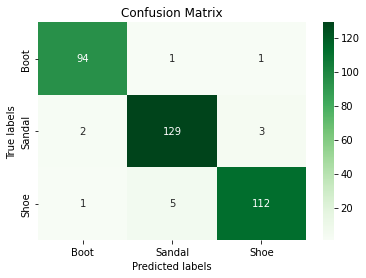

In [18]:
ax= plt.subplot()
sns.heatmap(confusion, annot=True, fmt='g', cmap = 'Greens', ax=ax); 

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Boot', 'Sandal', 'Shoe']); ax.yaxis.set_ticklabels(['Boot', 'Sandal', 'Shoe']);

### Random Forest

In [19]:
model_rf = RandomForestClassifier(n_estimators = 400)
model_rf.fit(x_train , y_train)

RandomForestClassifier(n_estimators=400)

In [20]:
pred = model_rf.predict(x_test)
confusion = confusion_matrix(y_test, pred)
acc = accuracy_score(y_test, pred)
print('Accuracy Score:',int(acc*100),'%')

Accuracy Score: 92 %


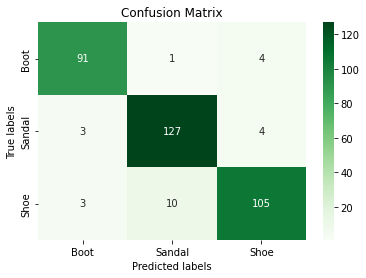

In [21]:
ax= plt.subplot()
sns.heatmap(confusion, annot=True, fmt='g', cmap = 'Greens', ax=ax); 

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Boot', 'Sandal', 'Shoe']); ax.yaxis.set_ticklabels(['Boot', 'Sandal', 'Shoe']);

### XGBoost

In [22]:
y = data_xgb.Type_enc
x = data_xgb.loc[:, data_features.columns != 'Type_enc']

x_train, x_test, y_train, y_test = train_test_split(x ,y,test_size = 0.3,random_state = 0)

In [23]:
model_xgb = xgb.XGBClassifier()
model_xgb.fit(x_train , y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [24]:
pred = model_xgb.predict(x_test)
confusion = confusion_matrix(y_test, pred)
acc = accuracy_score(y_test, pred)
print('Accuracy Score:',int(acc*100),'%')

Accuracy Score: 100 %


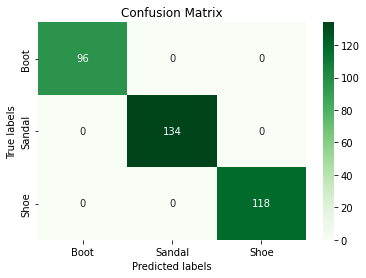

In [25]:
ax= plt.subplot()
sns.heatmap(confusion, annot=True, fmt='g', cmap = 'Greens', ax=ax); 

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Boot', 'Sandal', 'Shoe']); ax.yaxis.set_ticklabels(['Boot', 'Sandal', 'Shoe']);

## Result

Well, we have obtained a good accuracy for each method but XGBoost have impressed me, it was a really good classification, now i'm going to learn a form to use this in the entire group of images. If you read this far i would like to say thank you very much and if you think that i can improve something in this notebook please comment, it's going to be a good help :D